In [1]:
import requests
import torch
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Model

In [2]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")

In [3]:
print(model.config.label2id)
sorted(model.config.label2id)

{'bicycle': 18, 'building': 2, 'bus': 15, 'car': 13, 'fence': 4, 'motorcycle': 17, 'person': 11, 'pole': 5, 'rider': 12, 'road': 0, 'sidewalk': 1, 'sky': 10, 'terrain': 9, 'traffic light': 6, 'traffic sign': 7, 'train': 16, 'truck': 14, 'vegetation': 8, 'wall': 3}


['bicycle',
 'building',
 'bus',
 'car',
 'fence',
 'motorcycle',
 'person',
 'pole',
 'rider',
 'road',
 'sidewalk',
 'sky',
 'terrain',
 'traffic light',
 'traffic sign',
 'train',
 'truck',
 'vegetation',
 'wall']

# Load Cityscapes for testing

In [4]:
from torchvision.datasets import Cityscapes

c:\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Den angitte prosedyren ble ikke funnet'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
dataset = Cityscapes("./data/", split="val", mode="fine", target_type="semantic")
dataset

Dataset Cityscapes
    Number of datapoints: 500
    Root location: ./data/
    Split: val
    Mode: gtFine
    Type: ['semantic']

### Showing example from validation dataset

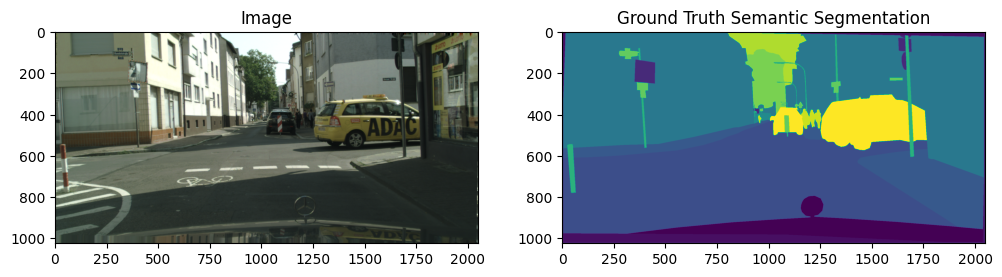

In [6]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].set_title("Image")
ax[0].imshow(dataset[0][0])
ax[1].set_title("Ground Truth Semantic Segmentation")
ax[1].imshow(dataset[0][1])

In [7]:
np.unique(dataset[0][1])

array([ 1,  2,  3,  4,  7,  8, 11, 13, 17, 20, 21, 23, 24, 26],
      dtype=uint8)

## Make labels in annotation dataset the same as for the model

In [8]:
#Checking which class Car is
bitmap = np.array(dataset[0][1])
bitmap[600][50]

17

In [10]:
#Marking every class that the model is not trained on to 19
model_to_ground_truth_mapping = {
    0:19,
    1:19,
    2:19,
    3:19,
    4:19,
    5:19,
    6:19,
    7:0,
    8:1,
    9:19,
    10:19,
    11:2,
    12:3,
    13:4,
    14:19,
    15:19,
    16:19,
    17:5,
    18:19,
    19:6,
    20:7,
    21:8,
    22:9,
    23:10,
    24:11,
    25:12,
    26:13,
    27:14,
    28:15,
    29:19,
    30:19,
    31:16,
    32:17,
    33:18
}

## Mapping values for one picture

In [11]:
def map_values(x):
    return model_to_ground_truth_mapping.get(x, x)

def map_picture(pic):
    vectorized_map_values = np.vectorize(map_values)
    vectorized_bitmap = vectorized_map_values(pic)
    return vectorized_bitmap


vectorized_bitmap = map_picture(bitmap)
print(vectorized_bitmap[600][50])

5


## Map the whole dataset

In [12]:
def map_dataset():
    mapped_dataset = []
    for i in range(len(dataset)):
        ground_truth_img = dataset[i][1]
        vectorized_map_values = np.vectorize(map_values)
        vectorized_bitmap = vectorized_map_values(bitmap)
        mapped_dataset.append(vectorized_bitmap)
    return mapped_dataset

## Prepare Image for the model using processor

In [22]:
from PIL import Image

 
image = dataset[1][0]

#dataset[3][0]
print(image)
inputs = processor(images=image, return_tensors="pt")
#0x2024AEECA00
#0x2024AEECA00
for k,v in inputs.items():
  print(k,v.shape)

<PIL.Image.Image image mode=RGB size=2048x1024 at 0x2330138C250>
pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])


## Forward Pass

In [23]:
with torch.no_grad():
  outputs = model(**inputs)

In [24]:
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(predicted_map[600][50])
type(predicted_map)

tensor(1)


torch.Tensor

In [25]:
def predict_picture(image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

In [16]:
vmin = min(predicted_map.min(), vectorized_bitmap.min())
vmax = max(predicted_map.max(), vectorized_bitmap.max())

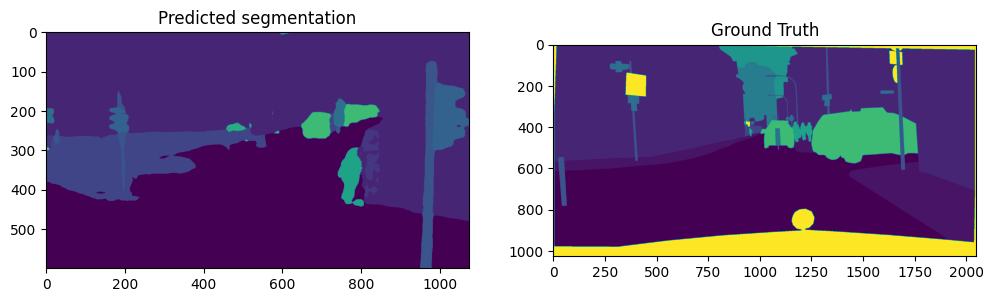

In [17]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].set_title("Predicted segmentation")
ax[0].imshow(predicted_map, vmin=vmin, vmax=vmax)
ax[1].set_title("Ground Truth")
ax[1].imshow(vectorized_bitmap, vmin=vmin, vmax=vmax)

In [18]:
predicted_map[500][800]
unique = torch.unique(predicted_map).numpy()
unique

array([ 0,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14], dtype=int64)

In [19]:
unique_elements = np.unique(vectorized_bitmap)
unique_elements

array([ 0,  1,  2,  4,  5,  7,  8, 10, 11, 13, 19])

# Plot of Predicted Map Over the Picture

In [20]:
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
print(color_palette)

[[1, 180, 190], [51, 192, 32], [119, 3, 229], [177, 220, 201], [199, 14, 250], [164, 96, 56], [138, 146, 178], [122, 192, 215], [223, 141, 37], [252, 44, 20], [224, 86, 253], [209, 144, 11], [44, 62, 61], [194, 18, 219], [59, 91, 91], [64, 67, 8], [217, 166, 140], [155, 174, 57], [151, 140, 53]]


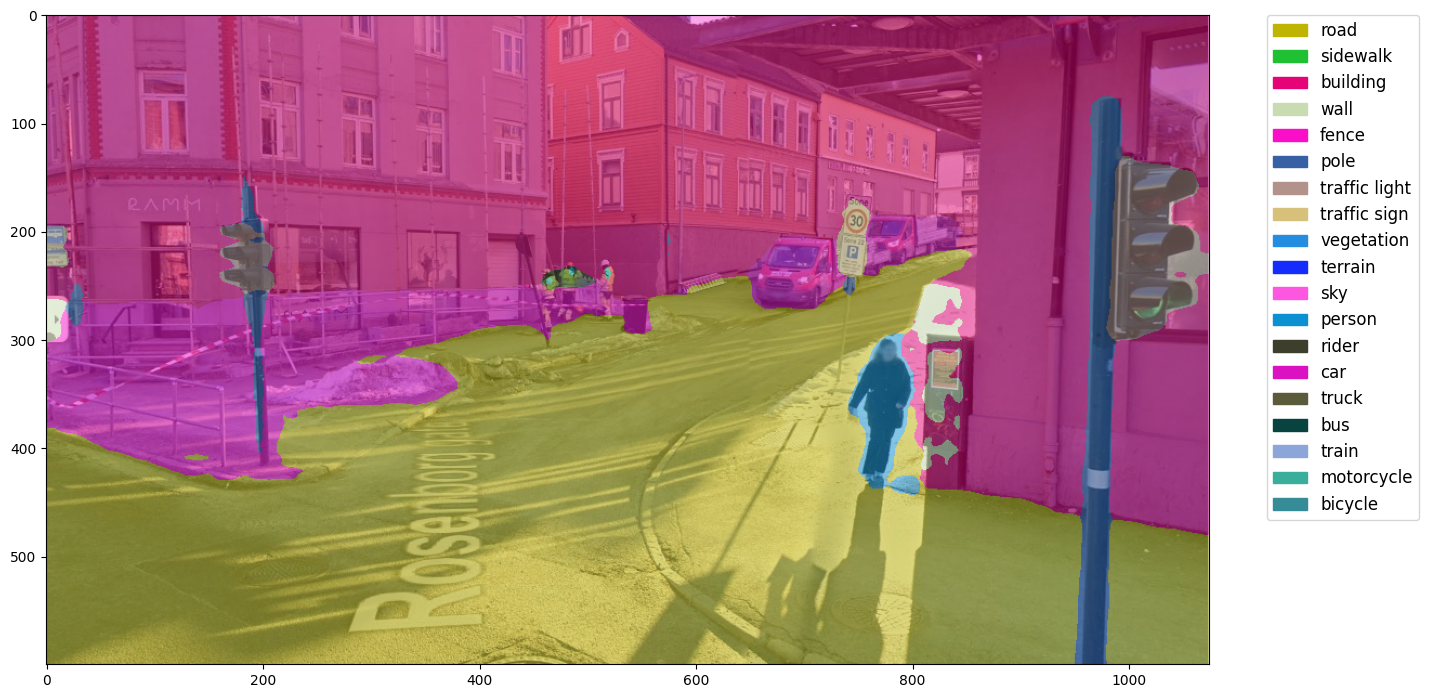

In [21]:
import matplotlib.patches as mpatches

reversed_label_dict = {value: key for key, value in model.config.label2id.items()}

seg = predicted_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)

handles = []
for label, color in enumerate(palette):
    # Convert the color from RGB to BGR for the legend
    bgr_color = color[::-1] / 255  # Convert to BGR and normalize to [0, 1]
    patch = mpatches.Patch(color=bgr_color, label=reversed_label_dict[label])
    handles.append(patch)

# Add the legend to the plot
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize="large")

plt.show()

# Evaluation of the model

## Pixel Accuracy

In [22]:
# Checking pixel accuracy on test picture, Im skipping every pixel that is 19 in the ground truth
# because the model isnt trained on these classes

In [23]:
def check_pixel_accuracy(predicted, ground_truth):
    correct = np.sum(predicted == ground_truth)
    unlabeled = np.sum(ground_truth == 19)
    total = ground_truth.size - unlabeled
    return correct * 100 / total 

check_pixel_accuracy(predicted_map.numpy(), vectorized_bitmap)

C:\Users\mathi\AppData\Local\Temp\ipykernel_40472\3030876738.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.sum(predicted == ground_truth)


0.0

In [26]:
import time
predicted_values_inherence = []
start_time = time.time()
for i in range(9):
    predicted_picture = predict_picture(dataset[i][0])
    predicted_values_inherence.append(predicted_picture.numpy())
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time taken for the loop: {elapsed_time} seconds")

Total time taken for the loop: 35.364243030548096 seconds


In [28]:
for i in range(9):
    print(i)


0
1
2
3
4
5
6
7
8


In [25]:
predicted_values = []
for i in range(len(dataset)):
    if i % 10 == 0:
        print(i)
    
    predicted_picture = predict_picture(dataset[i][0])
    predicted_values.append(predicted_picture.numpy())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [26]:
# Pixel Accuracy for all of the validation data 
pixel_accuracies = []
for i in range(len(predicted_values)):
    if i % 10 == 0:
        print(i)
    predicted_picture = predicted_values[i]
    ground_truth_picture = dataset[i][1]
    mapped_ground_truth = map_picture(ground_truth_picture)
    test = check_pixel_accuracy(predicted_picture, mapped_ground_truth)
    pixel_accuracies.append(test)
    
pixel_accuracies



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


[96.80659772825672,
 96.54775672008205,
 96.76915461490093,
 94.2668961741947,
 95.89083729891925,
 95.98293826567013,
 94.99611935150051,
 95.32065420215572,
 95.2556437053845,
 95.13405473212636,
 94.2661840001106,
 89.51979599897767,
 93.90269101432449,
 93.49190608773354,
 93.03754152806115,
 90.59018906351722,
 90.7799515934953,
 92.68751735671155,
 93.13055759724445,
 94.79233979031103,
 95.0088703294304,
 95.38371888302382,
 93.4232343722598,
 92.68215307367073,
 90.34802489660161,
 92.18084949948879,
 89.18514656652954,
 92.79619399423541,
 92.38428602136794,
 90.97749303987426,
 90.45368781605157,
 93.77333512166953,
 96.27440783960813,
 92.70102579853585,
 93.98342630085821,
 90.96740941829823,
 89.97873402510808,
 80.30159817025388,
 90.55627995856507,
 95.52836423023227,
 93.49118102512635,
 94.50051617868291,
 93.45873832874778,
 94.39576210168187,
 92.96741966586228,
 94.85119121974428,
 95.10177366920718,
 95.2485063748201,
 95.04899606934828,
 93.17478499863196,
 91.069

In [27]:
import statistics

statistics.mean(pixel_accuracies)

93.760253161956

## Check how good the model performs on Cars and Traffic Signs

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


## Calculation of IoU

In [29]:
def check_pixel_accuracy_on_class(predicted, ground_truth, class_id):
    correct = np.sum((predicted == class_id) & (ground_truth == class_id))
    total = np.sum((predicted == class_id) | (ground_truth == class_id))
    return correct * 100 / total

print(check_pixel_accuracy_on_class(predicted_map.numpy(), vectorized_bitmap, 13)) #Cars
check_pixel_accuracy_on_class(predicted_map.numpy(), vectorized_bitmap, 7) #Traffic lights

ValueError: operands could not be broadcast together with shapes (600,1074) (1024,2048) 

In [30]:
pixel_accuracy_class = {}

for i in range(len(model.config.label2id)):
    for j in range(len(predicted_values)):
        ground_truth_picture = dataset[j][1]
        mapped_ground_truth = map_picture(ground_truth_picture)
        accuracy = check_pixel_accuracy_on_class(predicted_values[j], mapped_ground_truth, i)
        calculated_accuracies = pixel_accuracy_class.get(i)
        if calculated_accuracies is None:
            pixel_accuracy_class[i] = []
        pixel_accuracy_class.get(i).append(accuracy)




C:\Users\mathi\AppData\Local\Temp\ipykernel_40472\629373114.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return correct * 100 / total


In [31]:
print(pixel_accuracy_class)
np.unique(predicted_values[0])
pixel_accuracy_class[0]

{0: [89.01754806546695, 86.48351781139736, 83.5311320189369, 79.88513770526299, 84.52863819756206, 88.8961111195936, 83.87345598255085, 84.43896213299215, 80.9932885027712, 82.68210647911913, 85.68667299315189, 77.68911535973218, 83.65932620115994, 82.91598799509335, 85.07139933119613, 80.75464792169156, 79.93286208291666, 83.23566274855187, 80.67605059240321, 79.63381341197922, 81.78287884017949, 79.97461503693775, 82.91431149581422, 86.43076187197975, 78.36495226895407, 80.80448089018354, 76.62338137569648, 84.54549937266805, 79.6725947211039, 81.08587481135035, 81.98142067466692, 78.29047196337288, 88.64126016766993, 84.42366649210223, 84.74361102823967, 79.9353448275862, 80.49068483295295, 66.72453644777974, 74.22222961952, 74.23373238682717, 86.89197230194044, 86.17162938472838, 85.79889361500643, 86.37882938050842, 84.51027631731924, 78.26015244613144, 82.43228389730706, 83.26905640856391, 82.35026043021448, 82.5048692148426, 84.78744406491884, 79.36365115678035, 81.4384009929361

[89.01754806546695,
 86.48351781139736,
 83.5311320189369,
 79.88513770526299,
 84.52863819756206,
 88.8961111195936,
 83.87345598255085,
 84.43896213299215,
 80.9932885027712,
 82.68210647911913,
 85.68667299315189,
 77.68911535973218,
 83.65932620115994,
 82.91598799509335,
 85.07139933119613,
 80.75464792169156,
 79.93286208291666,
 83.23566274855187,
 80.67605059240321,
 79.63381341197922,
 81.78287884017949,
 79.97461503693775,
 82.91431149581422,
 86.43076187197975,
 78.36495226895407,
 80.80448089018354,
 76.62338137569648,
 84.54549937266805,
 79.6725947211039,
 81.08587481135035,
 81.98142067466692,
 78.29047196337288,
 88.64126016766993,
 84.42366649210223,
 84.74361102823967,
 79.9353448275862,
 80.49068483295295,
 66.72453644777974,
 74.22222961952,
 74.23373238682717,
 86.89197230194044,
 86.17162938472838,
 85.79889361500643,
 86.37882938050842,
 84.51027631731924,
 78.26015244613144,
 82.43228389730706,
 83.26905640856391,
 82.35026043021448,
 82.5048692148426,
 84.78744

In [32]:
pixel_accuracy_class_avg = {}
for i in range(19):
    pixel_accuracy_class_avg[i] = np.nanmean(pixel_accuracy_class[i])

print(pixel_accuracy_class_avg)

{0: 80.47837521994651, 1: 63.382143914223356, 2: 71.364472626667, 3: 18.96269513382556, 4: 15.65079192102454, 5: 31.192060329021302, 6: 28.053436265712993, 7: 46.49794206249375, 8: 80.10044087186245, 9: 27.105286667636612, 10: 77.03597435731926, 11: 34.95430415769852, 12: 21.139617407588737, 13: 76.83987897826798, 14: 20.187133268583803, 15: 44.68268773120518, 16: 20.67474259171875, 17: 10.901612259830996, 18: 32.74750046014997}


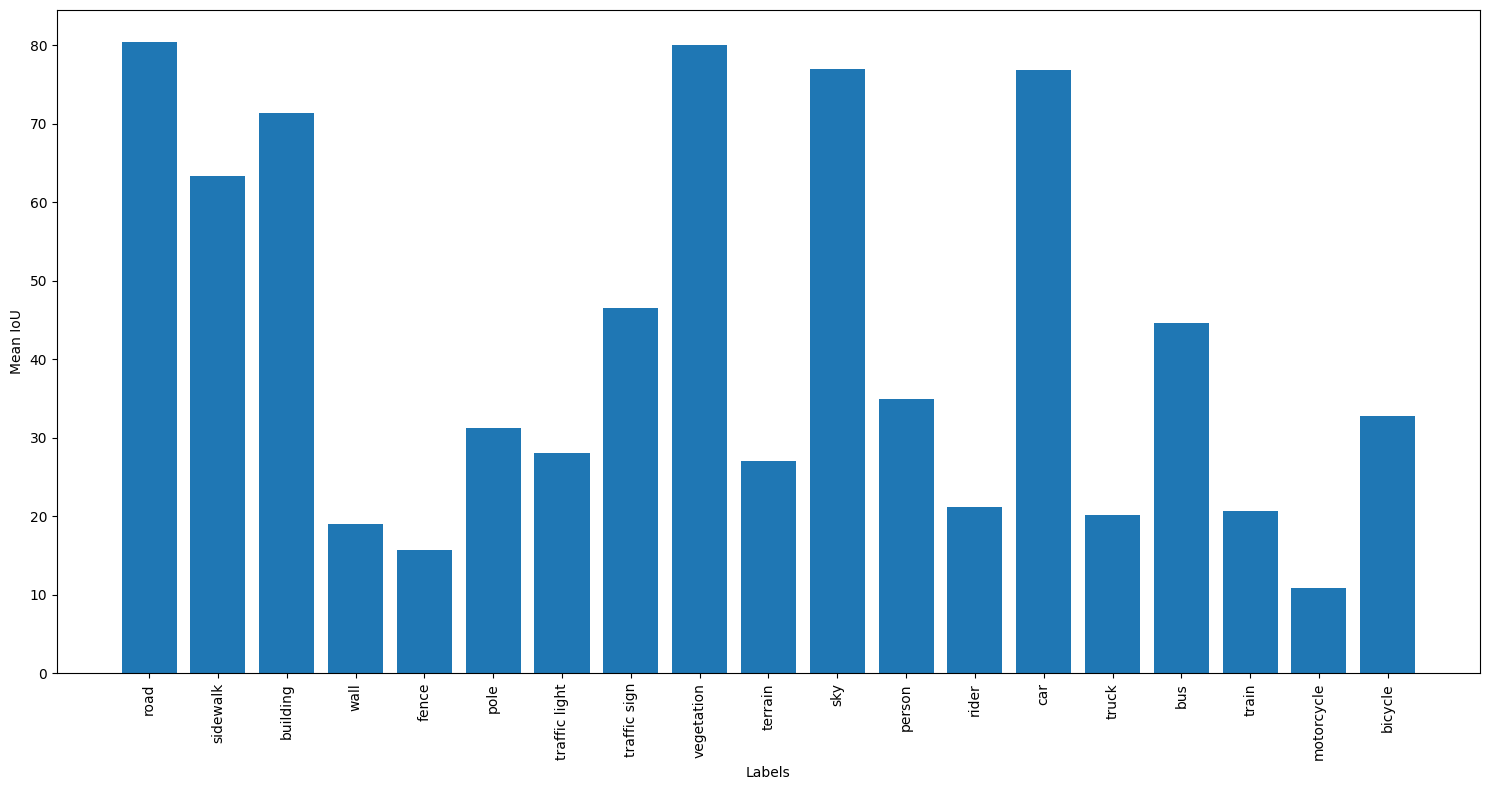

In [33]:
import matplotlib.pyplot as plt

# Provided label data
def plot_occurrences(counts):
    labels = [
        'road', 'sidewalk','building', 'wall', 'fence', 'pole', 
        'traffic light', 'traffic sign', 'vegetation', 'terrain', 
        'sky', 'person', 'rider', 'car', 'truck', 'bus',
        'train', 'motorcycle', 'bicycle'
    ]

    # Filter labels and counts to include only those present in the counts dictionary
    filtered_labels = [label for i, label in enumerate(labels) if i in counts]
    filtered_counts = [counts[i] for i in range(len(labels)) if i in counts]

    # Create the matplotlib bar chart
    plt.figure(figsize=(15, 8))
    plt.bar(filtered_labels, filtered_counts)
    plt.xlabel('Labels')
    plt.ylabel('Mean IoU')
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.tight_layout()  # Adjust layout to fit all labels
    plt.show()

plot_occurrences(pixel_accuracy_class_avg)